
# Source detection and significance maps

Build a list of significant excesses in a Fermi-LAT map.

## Context

The first task in a source catalog production is to identify
significant excesses in the data that can be associated to unknown
sources and provide a preliminary parametrization in terms of position,
extent, and flux. In this notebook we will use Fermi-LAT data to
illustrate how to detect candidate sources in counts images with known
background.

**Objective: build a list of significant excesses in a Fermi-LAT map**

## Proposed approach

This notebook show how to do source detection with Gammapy using the
methods available in `~gammapy.estimators`. We will use images from a
Fermi-LAT 3FHL high-energy Galactic center dataset to do this:

-  perform adaptive smoothing on counts image
-  produce 2-dimensional test-statistics (TS)
-  run a peak finder to detect point-source candidates
-  compute Li & Ma significance images
-  estimate source candidates radius and excess counts

Note that what we do here is a quick-look analysis, the production of
real source catalogs use more elaborate procedures.

We will work with the following functions and classes:

-  `~gammapy.maps.WcsNDMap`
-  `~gammapy.estimators.ASmoothMapEstimator`
-  `~gammapy.estimators.TSMapEstimator`
-  `~gammapy.estimators.utils.find_peaks`


## Setup

As always, let’s get started with some setup …




In [1]:
import numpy as np
import astropy.units as u

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.datasets import MapDataset
from gammapy.estimators import ASmoothMapEstimator, TSMapEstimator
from gammapy.estimators.utils import find_peaks, find_peaks_in_flux_map
from gammapy.irf import EDispKernelMap, PSFMap
from gammapy.maps import Map
from gammapy.modeling.models import PointSpatialModel, PowerLawSpectralModel, SkyModel

## Check setup



In [2]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()


System:

	python_executable      : /Users/tharacaba/miniconda3/envs/gammapy-1.3/bin/python 
	python_version         : 3.11.11    
	machine                : arm64      
	system                 : Darwin     


Gammapy package:

	version                : 1.3        
	path                   : /Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy 


Other packages:

	numpy                  : 2.1.3      
	scipy                  : 1.14.1     
	astropy                : 6.1.6      
	regions                : 0.10       
	click                  : 8.1.8      
	yaml                   : 6.0.2      
	IPython                : 8.27.0     
	jupyterlab             : 4.2.7      
	matplotlib             : 3.9.4      
	pandas                 : 2.2.3      
	healpy                 : 1.18.0     
	iminuit                : 2.30.1     
	sherpa                 : not installed 
	naima                  : 0.10.2     
	emcee                  : 3.1.6      
	corner                 : 2.2.3   

## Read in input images

We first read the relevant maps:




In [3]:
counts = Map.read("$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-counts-cube.fits.gz")
background = Map.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-background-cube.fits.gz"
)

exposure = Map.read("$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-exposure-cube.fits.gz")

psfmap = PSFMap.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-psf-cube.fits.gz",
    format="gtpsf",
)

edisp = EDispKernelMap.from_diagonal_response(
    energy_axis=counts.geom.axes["energy"],
    energy_axis_true=exposure.geom.axes["energy_true"],
)

dataset = MapDataset(
    counts=counts,
    background=background,
    exposure=exposure,
    psf=psfmap,
    name="fermi-3fhl-gc",
    edisp=edisp,
)

Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 57236.967546 from DATE-END'. [astropy.wcs.wcs]


## Adaptive smoothing

For visualisation purpose it can be nice to look at a smoothed counts
image. This can be performed using the adaptive smoothing algorithm from
[Ebeling et
al. (2006)](https://ui.adsabs.harvard.edu/abs/2006MNRAS.368...65E/abstract)_.

In the following example the `ASmoothMapEstimator.threshold` argument gives the minimum
significance expected, values below are clipped.




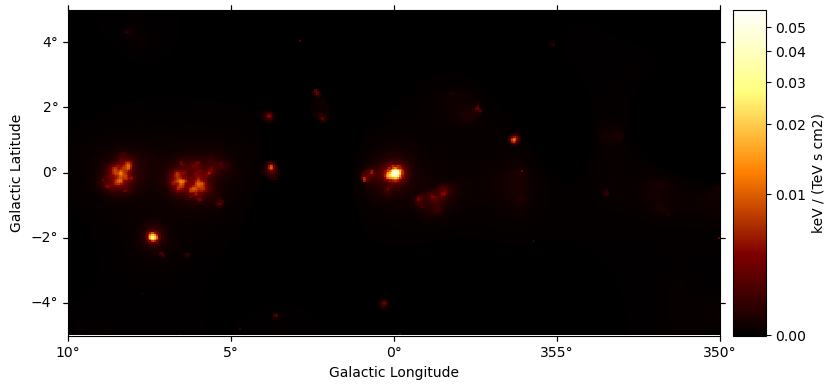

In [4]:
scales = u.Quantity(np.arange(0.05, 1, 0.05), unit="deg")
smooth = ASmoothMapEstimator(threshold=3, scales=scales, energy_edges=[10, 500] * u.GeV)
images = smooth.run(dataset)

plt.figure(figsize=(9, 5))
images["flux"].plot(add_cbar=True, stretch="asinh")
plt.show()

## TS map estimation

The Test Statistic, $TS = 2 \Delta log L$ ([Mattox et
al. 1996](https://ui.adsabs.harvard.edu/abs/1996ApJ...461..396M/abstract)_),
compares the likelihood function L optimized with and without a given
source. The TS map is computed by fitting by a single amplitude
parameter on each pixel as described in Appendix A of [Stewart
(2009)](https://ui.adsabs.harvard.edu/abs/2009A%26A...495..989S/abstract)_.
The fit is simplified by finding roots of the derivative of the fit
statistics (default settings use [Brent’s
method](https://en.wikipedia.org/wiki/Brent%27s_method)_).

We first need to define the model that will be used to test for the
existence of a source. Here, we use a point source.




In [5]:
spatial_model = PointSpatialModel()

# We choose units consistent with the map units here...
spectral_model = PowerLawSpectralModel(amplitude="1e-22 cm-2 s-1 keV-1", index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

Here we show a full configuration of the estimator. We remind the user of the meaning
of the various quantities:

-  ``model``: a `~gammapy.modeling.models.SkyModel` which is converted to a source model kernel
-  ``kernel_width``: the width for the above kernel
-  ``n_sigma``: number of sigma for the flux error
-  ``n_sigma_ul``: the number of sigma for the flux upper limits
-  ``selection_optional``: what optional maps to compute
-  ``n_jobs``: for running in parallel, the number of processes used for the computation
-  ``sum_over_energy_groups``: to sum over the energy groups or fit the `norm` on the full energy cube



In [6]:
estimator = TSMapEstimator(
    model=model,
    kernel_width="1 deg",
    energy_edges=[10, 500] * u.GeV,
    n_sigma=1,
    n_sigma_ul=2,
    selection_optional=None,
    n_jobs=1,
    sum_over_energy_groups=True,
)


maps = estimator.run(dataset)

### Accessing and visualising results

Below we print the result of the `~gammapy.estimators.TSMapEstimator`. We have access to a number of
different quantities, as shown below. We can also access the quantities names
through ``map_result.available_quantities``.




In [7]:
print(maps)

FluxMaps
--------

  geom                   : WcsGeom
  axes                   : ['lon', 'lat', 'energy']
  shape                  : (np.int64(400), np.int64(200), 1)
  quantities             : ['ts', 'norm', 'niter', 'norm_err', 'npred', 'npred_excess', 'stat', 'stat_null', 'success']
  ref. model             : pl
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : likelihood



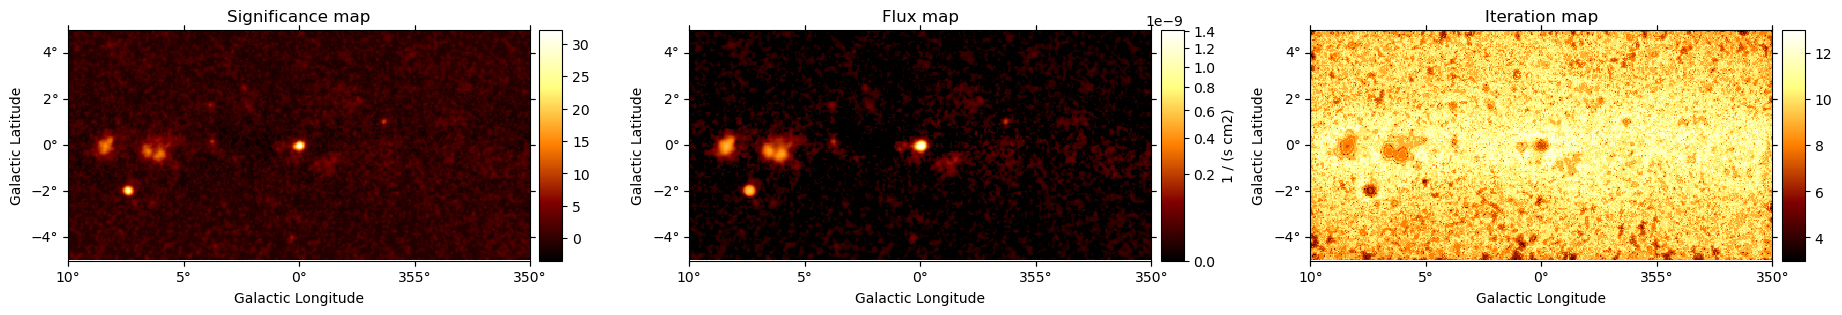

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3,
    figsize=(20, 3),
    subplot_kw={"projection": counts.geom.wcs},
    gridspec_kw={"left": 0.1, "right": 0.98},
)

maps["sqrt_ts"].plot(ax=ax1, add_cbar=True)
ax1.set_title("Significance map")
maps["flux"].plot(ax=ax2, add_cbar=True, stretch="sqrt", vmin=0)
ax2.set_title("Flux map")
maps["niter"].plot(ax=ax3, add_cbar=True)
ax3.set_title("Iteration map")
plt.show()

The flux in each pixel is obtained by multiplying a reference model with a
normalisation factor:



In [9]:
print(maps.reference_model)

SkyModel

  Name                      : V-ks0Olf
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   1.00e-22   +/- 0.0e+00 1 / (keV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :      0.000   +/-    0.00 deg         
    lat_0                         :      0.000   +/-    0.00 deg         




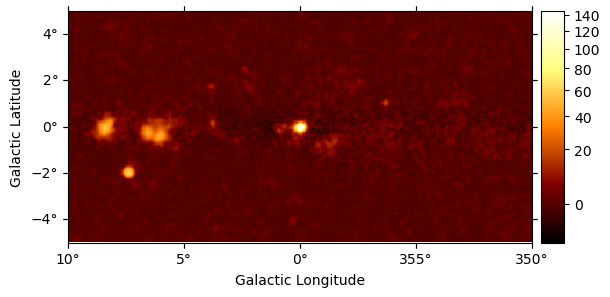

In [10]:
maps.norm.plot(add_cbar=True, stretch="sqrt")
plt.show()

## Source candidates

Let’s run a peak finder on the `sqrt_ts` image to get a list of
point-sources candidates (positions and peak `sqrt_ts` values). The
`~gammapy.estimators.utils.find_peaks` function performs a local maximum search in a sliding
window, the argument `min_distance` is the minimum pixel distance
between peaks (smallest possible value and default is 1 pixel).




value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
32.194,200,99,266.41449,-28.97054
27.833,52,60,272.43197,-23.54282
15.16,32,98,271.16056,-21.74479
14.134,69,93,270.40919,-23.47797
13.872,80,92,270.15899,-23.98049
9.7638,273,119,263.18257,-31.52587
8.793,124,102,268.46711,-25.63326
7.3491,123,134,266.97596,-24.77174


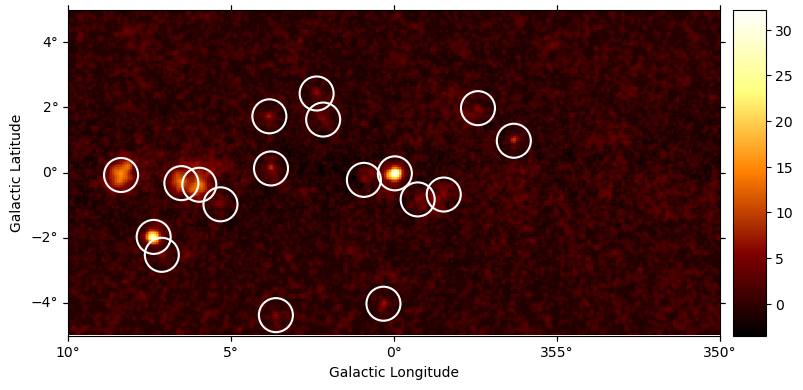

In [11]:
sources = find_peaks(maps["sqrt_ts"], threshold=5, min_distance="0.25 deg")
nsou = len(sources)
display(sources)

# Plot sources on top of significance sky image
plt.figure(figsize=(9, 5))
ax = maps["sqrt_ts"].plot(add_cbar=True)

ax.scatter(
    sources["ra"],
    sources["dec"],
    transform=ax.get_transform("icrs"),
    color="none",
    edgecolor="w",
    marker="o",
    s=600,
    lw=1.5,
)
plt.show()

# sphinx_gallery_thumbnail_number = 3

We can also utilise `~gammapy.estimators.utils.find_peaks_in_flux_map`
to display various parameters from the FluxMaps



In [12]:
sources_flux_map = find_peaks_in_flux_map(maps, threshold=5, min_distance="0.25 deg")
display(sources_flux_map)

x,y,ra,dec,ts,norm,niter,norm_err,npred,npred_excess,stat,stat_null,success,flux,flux_err
,,deg,deg,,,,,,,,,,1 / (s cm2),1 / (s cm2)
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64
93,80,270.37773,-24.84233,25.41555,8.27043,8.0,2.37914,290.78937,27.07074,815.20556,840.62111,True,8.105e-11,2.332e-11
156,132,266.12148,-26.23306,25.67442,6.00005,8.0,1.89724,155.88363,19.73494,666.92009,692.59451,True,5.880e-11,1.859e-11
57,49,272.82739,-24.02653,26.76643,5.68610,7.0,1.76385,106.04843,18.55966,696.93904,723.70546,True,5.572e-11,1.729e-11
214,83,266.78188,-29.98429,29.38654,9.89249,9.0,2.63543,450.31686,32.72392,809.50127,838.88781,True,9.695e-11,2.583e-11
181,95,267.17020,-28.26173,29.93437,13.12076,9.0,3.22925,697.64627,43.25799,629.45787,659.39224,True,1.286e-10,3.165e-11
251,139,262.90685,-30.05853,31.98741,6.79990,8.0,1.95252,174.09938,22.54051,734.23408,766.22149,True,6.664e-11,1.913e-11
127,12,272.77351,-27.97934,32.12432,4.19126,8.0,1.37638,62.78010,13.76505,401.25085,433.37517,True,4.107e-11,1.349e-11
230,86,266.15140,-30.58926,34.46172,13.03987,9.0,3.10155,500.87813,43.20346,831.08720,865.54892,True,1.278e-10,3.040e-11


Note that we used the instrument point-spread-function (PSF) as kernel,
so the hypothesis we test is the presence of a point source. In order to
test for extended sources we would have to use as kernel an extended
template convolved by the PSF. Alternatively, we can compute the
significance of an extended excess using the Li & Ma formalism, which is
faster as no fitting is involve.




## What next?

In this notebook, we have seen how to work with images and compute TS
and significance images from counts data, if a background estimate is
already available.

Here’s some suggestions what to do next:

-  Look how background estimation is performed for IACTs with and
   without the high level interface in
   :doc:`/tutorials/starting/analysis_1` and
   :doc:`/tutorials/starting/analysis_2` notebooks,
   respectively
-  Learn about 2D model fitting in the :doc:`/tutorials/analysis-2d/modeling_2D` notebook
-  Find more about Fermi-LAT data analysis in the
   :doc:`/tutorials/data/fermi_lat` notebook
-  Use source candidates to build a model and perform a 3D fitting (see
   :doc:`/tutorials/analysis-3d/analysis_3d`,
   :doc:`/tutorials/analysis-3d/analysis_mwl` notebooks for some hints)


